<h1>Benchmarking Darcy flow using manufactured solutions</h1>
<p>
    This notebook demonstrates how one can solve Darcy's flow using the mixed Poisson formulation. It also shows the idea of utilizing class inheritance to expand the existing code structure. This benchmark problem is based on Ada Johanne Ellingsrud's masters thesis: Preconditioning unified mixed discretization of coupled Darcy-Stokes flow. <a href="https://www.duo.uio.no/bitstream/handle/10852/45338/paper.pdf" target="_blank">[link]</a>
</p>

In [1]:
from dolfin import Constant, Expression, plot, inner, interpolate, assemble
from dolfin.common.plotting import mplot_function

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../../')
from reaktoro_transport.problem import DarcyFlowMixedPoisson
from reaktoro_transport.mesh import MarkedRectangleMesh

%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [2]:
mesh_factory = MarkedRectangleMesh()

In [3]:
mesh_factory.set_bottom_left_coordinates(coord_x = -1.0, coord_y = -1.0)
mesh_factory.set_top_right_coordinates(coord_x = 1.0, coord_y = 1.0)
mesh_factory.set_number_of_elements(10, 10)
mesh_factory.set_mesh_type('triangle')
mesh = mesh_factory.generate_mesh()
boundary_markers, marker_dict = mesh_factory.set_boundary_markers()
domain_markers = mesh_factory.set_domain_markers()

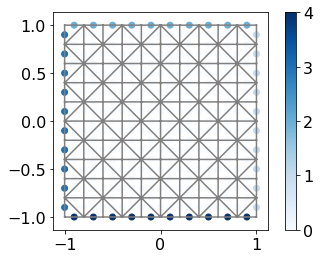

In [4]:
fig, ax = plt.subplots(1,1)
plot(mesh)
cb = mesh_factory.plot_boundary_markers(ax)
fig.colorbar(cb)
plt.show()

In [5]:
class DarcyFlowBenchmarkProblem(DarcyFlowMixedPoisson):
    def add_source_term(self):
        v  = self._DarcyFlowMixedPoisson__v
        mu = self._DarcyFlowMixedPoisson__mu
        k  = self._DarcyFlowMixedPoisson__k
        
        source1 = Expression(('sin(M_PI*x[1])', 'cos(M_PI*x[0])'), degree=1)
        source2 = Expression(('M_PI*cos(M_PI*x[0])*exp(x[1])', 'sin(M_PI*x[0])*exp(x[1])'), degree=1)
        
        self.mixed_form -= (mu/k*inner(v, source1) + inner(v, source2))*self.dx
    
    def get_solution(self):
        self.sol_pressure = interpolate(Expression('exp(x[1])*sin(M_PI*x[0])', degree=1), self.pressure_func_space)
        self.sol_velocity = interpolate(Expression(('sin(M_PI*x[1])', 'cos(M_PI*x[0])'), degree=1),
                                   self.velocity_func_space)
        
        return self.sol_pressure, self.sol_velocity
    
    def get_error_norm(self):
        
        pressure_norm = np.sqrt(assemble((self.sol_pressure-self.fluid_pressure)**2*self.dx))
        velocity_norm = np.sqrt(assemble((self.sol_velocity-self.fluid_velocity)**2*self.dx))
        
        return pressure_norm, velocity_norm
        
problem = DarcyFlowBenchmarkProblem(mesh, boundary_markers, domain_markers)

In [6]:
problem.mark_flow_boundary(pressure = [marker_dict['left'], marker_dict['right']],
                           velocity = [marker_dict['top'], marker_dict['bottom']])

problem.set_permeability(Constant(1.0))
problem.set_fluid_density(1.0)
problem.set_fluid_viscosity(1.0)
problem.set_gravity((0.0, 0.0))
problem.set_form_and_pressure_bc([0.0, 0.0])
problem.set_velocity_bc([Expression(('sin(M_PI*x[1])', 'cos(M_PI*x[0])'), degree=1)]*2)

problem.set_solver()

In [7]:
problem.add_source_term()
problem.assemble_matrix()

In [8]:
%%time

problem.solve_flow()

CPU times: user 5.66 ms, sys: 735 µs, total: 6.39 ms
Wall time: 6.25 ms


In [9]:
velocity = problem.get_fluid_velocity()
pressure = problem.get_fluid_pressure()

solution_p, solution_v = problem.get_solution()

print(problem.get_error_norm())

(0.07406940102045532, 0.09801194691675154)


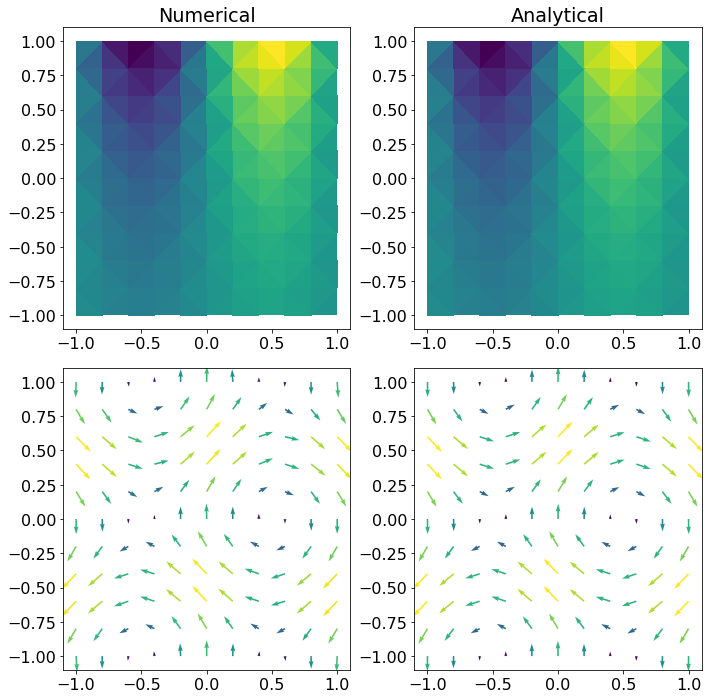

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

mplot_function(ax[0,0], pressure)
mplot_function(ax[1,0], velocity)

mplot_function(ax[0,1], solution_p)
mplot_function(ax[1,1], solution_v)

ax[0,0].set_title('Numerical')
ax[0,1].set_title('Analytical')

plt.tight_layout()
plt.show()